In [1]:
import glob
import xmitgcm
from xmitgcm import open_mdsdataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
from xgcm import Grid
#import numba
matplotlib.rcParams.update({'font.size': 20})
import matplotlib.transforms as mtransforms

In [2]:
def getoutput(data_dir,prefix,step):
    l=glob.glob(data_dir+prefix+'*')
    R=[i.split('.00', 1)[1] for i in l]
    S=[i.split('.', 1)[0] for i in R]
    T=[int(i) for i in S]
    T.sort()
    iters=T[step:]
    deltaTClock = 21600.
    grid_dir = './K5000_plume/'
    data = open_mdsdataset(data_dir,grid_dir,iters=iters,delta_t=deltaTClock,prefix=prefix,geometry='sphericalpolar',default_dtype=np.dtype)
    return data

In [3]:
num=-4
lay500=getoutput('./K500/','layersDiags',num)
lay5000=getoutput('./K5000_plume/','layersDiags',num)
lay2000=getoutput('./K2000/','layersDiags',num)
lay5002=getoutput('./K500_taux2/','layersDiags',num)
lay50002=getoutput('./K5000_taux2/','layersDiags',num)
lay20002=getoutput('./K2000_taux2/','layersDiags',num)

In [4]:
num=-360
lay5002=getoutput('./K500_taux2/','layersDiags',num)

In [3]:
num=-40
dyn500=getoutput('./K500/','dyn',num)
dyn5000=getoutput('./K5000_plume/','dyn',num)
dyn2000=getoutput('./K2000/','dyn',num)
dyn5002=getoutput('./K500_taux2/','dyn',num)
dyn50002=getoutput('./K5000_taux2/','dyn',num)
dyn20002=getoutput('./K2000_taux2/','dyn',num)

In [4]:
num=-360
dyn5002=getoutput('./K500_taux2/','dyn',num)

In [7]:
def coverter_time(lay):
    weight=lay['dxG']
    density_to_depth = (((lay['LaHs1RHO'].mean('time')*lay['hFacS'][0]).weighted(weight)).sum('XC').cumsum('layer_1RHO_center'))/(lay['dxG'].sum('XC'))
    stream1 = (((lay['LaVH1RHO'].mean('time')*lay['hFacS'][0]).weighted(weight)).sum('XC').cumsum('layer_1RHO_center'))
    layers_depth=(lay['LaHs1RHO'].mean('time')*lay['hFacS'][0]).mean('XC').cumsum('layer_1RHO_center')
    layers_depth_atl=((lay['LaHs1RHO'].mean('time')*lay['hFacS'][0]*lay['dxG']).sum('XC')/lay['dxG'].sum('XC')).cumsum('layer_1RHO_center')
    stream1.coords['depth']=-layers_depth_atl
    layer_1RHO_center_new = xr.DataArray(layers_depth_atl, dims=['layer_1RHO_bounds','YG'], coords={'layer_1RHO_bounds': lay.layer_1RHO_bounds[:-1] ,'YG':lay.YG})
    layer2D,_=(xr.broadcast(-9.81*(lay.layer_1RHO_bounds-35)/1035, lay.YG))
    layer2D.coords['depth']=(-layer_1RHO_center_new)
    return stream1,layer2D,layers_depth

In [8]:
def density(dyn):
    buoy=(9.81*(2e-4*dyn['THETA'].mean('time')-7.4e-4*(dyn['SALT'].mean('time')-35)))
    buoy=(buoy*dyn.hFacC*dyn.dxF).sum('XC')/(dyn.hFacC*dyn.dxF).sum('XC')
    return buoy

In [9]:
d500=density(dyn500)
d5000=density(dyn5000)
d2000=density(dyn2000)
d5002=density(dyn5002)
d50002=density(dyn50002)
d20002=density(dyn20002)

/scratch/user/nicole.neumann-2/.conda/envs/myjup/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/user/nicole.neumann-2/.conda/envs/myjup/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/user/nicole.neumann-2/.conda/envs/myjup/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/user/nicole.neumann-2/.conda/envs/myjup/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/user/nicole.neumann-2/.conda/envs/myjup/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cac

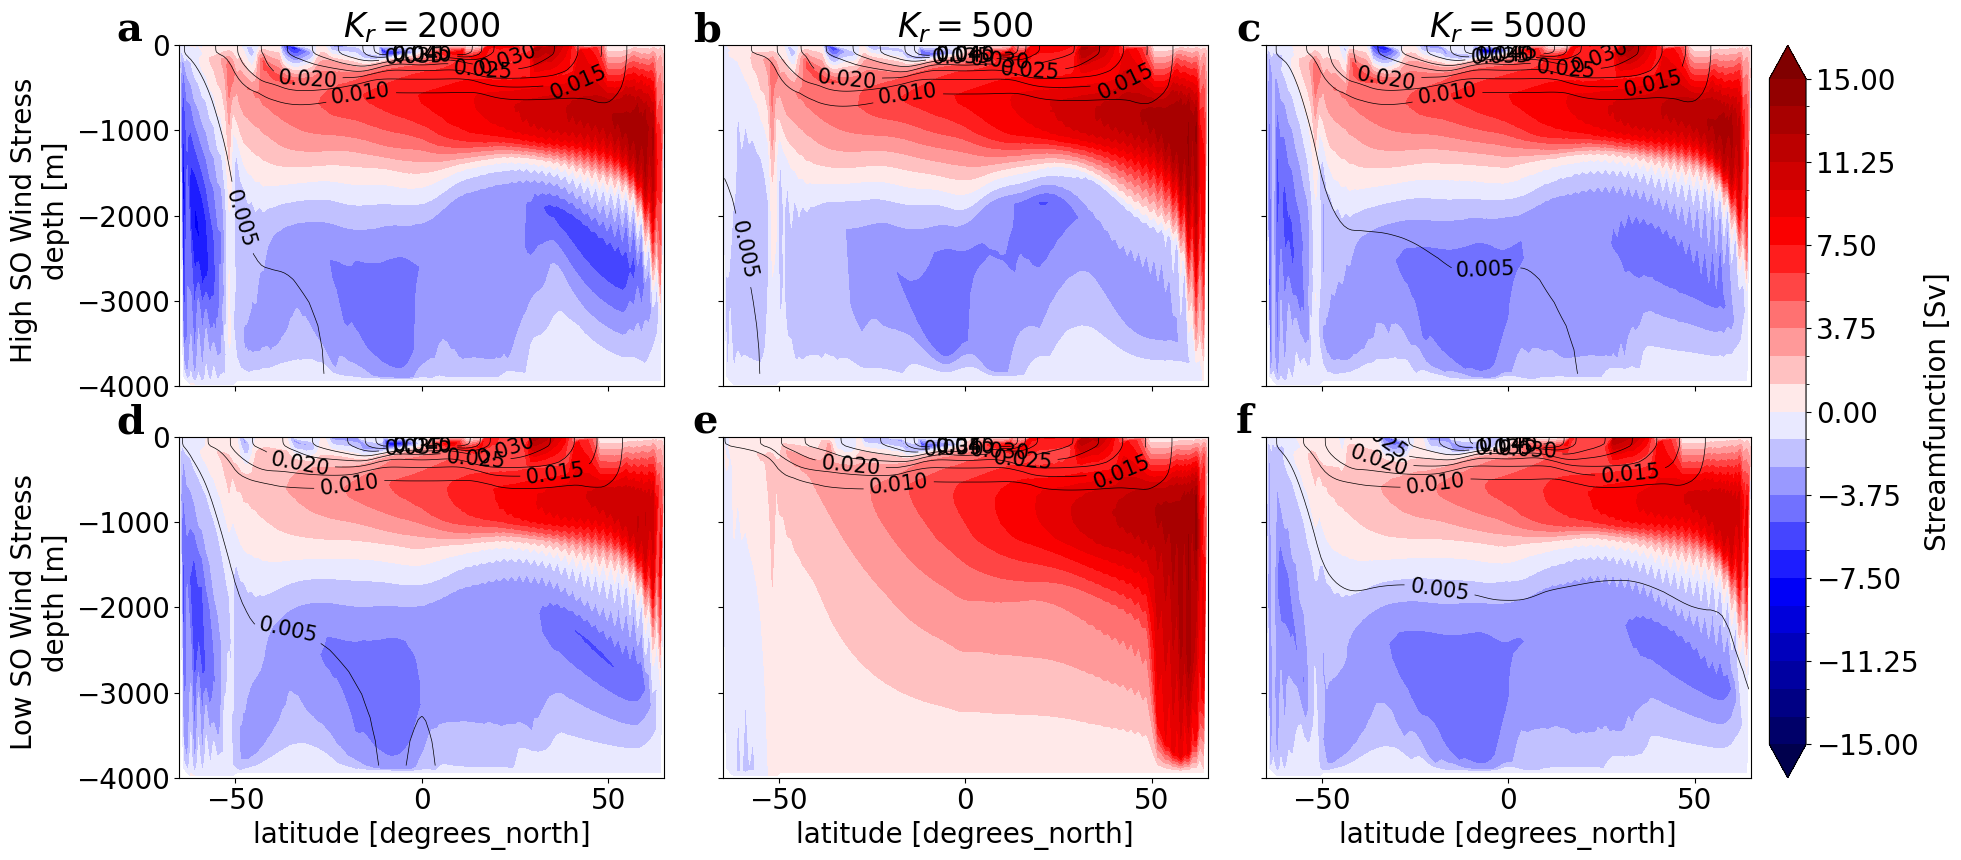

In [11]:
fig, axs = plt.subplots(ncols=3,nrows=2,figsize=(21,9),sharex=True)
stream5000, con5000, depth5000 = coverter_time(lay5000)
stream500, con500, depth500 = coverter_time(lay500)
stream2000, con2000, depth2000 = coverter_time(lay2000)

stream50002, con50002, depth50002 = coverter_time(lay50002)
stream5002, con5002, depth5002 = coverter_time(lay5002)
stream20002, con20002, depth20002 = coverter_time(lay20002)

cmap='seismic'
mins=-15
maxs=15

C = ((stream5000/1e6)).plot.contourf(ax=axs[1,2],x='YG',y='depth',cmap=cmap,ylim=(-4000,0),add_colorbar=False,vmin=mins,vmax=maxs,extend='both',yticks=None,levels=25,yincrease=False)
cc=(d5000).plot.contour(ax=axs[1,2],x='YC',y='Z',levels=np.arange(0,0.05,0.005),colors='black',linewidths=0.5)
plt.clabel(cc, cc.levels, inline=True,  fontsize=15)
                      
C = ((stream500/1e6)).plot.contourf(ax=axs[1,1],x='YG',y='depth',cmap=cmap,ylim=(-4000,0),vmin=mins,add_colorbar=False,vmax=maxs,extend='both',levels=25,yincrease=False)
cc=(d500).plot.contour(ax=axs[1,1],x='YC',y='Z',levels=np.arange(0,0.05,0.005),colors='black',linewidths=0.5)
plt.clabel(cc, cc.levels, inline=True,  fontsize=15)

C = ((stream2000/1e6)).plot.contourf(ax=axs[1,0],x='YG',y='depth',cmap=cmap,ylim=(-4000,0),vmin=mins,add_colorbar=False,vmax=maxs,extend='both',levels=25,yincrease=False)
cc=(d2000).plot.contour(ax=axs[1,0],x='YC',y='Z',levels=np.arange(0,0.05,0.005),colors='black',linewidths=0.5)
plt.clabel(cc, cc.levels, inline=True,  fontsize=15)

                      
C = ((stream50002/1e6)).plot.contourf(ax=axs[0,2],x='YG',y='depth',cmap=cmap,ylim=(-4000,0),add_colorbar=False,vmin=mins,vmax=maxs,extend='both',yticks=None,levels=25,yincrease=False)
cc=(d50002).plot.contour(ax=axs[0,2],x='YC',y='Z',levels=np.arange(0,0.05,0.005),colors='black',linewidths=0.5)
plt.clabel(cc, cc.levels, inline=True,  fontsize=15)

C = ((stream5002/1e6)).plot.contourf(ax=axs[0,1],x='YG',y='depth',cmap=cmap,ylim=(-4000,0),vmin=mins,add_colorbar=False,vmax=maxs,extend='both',levels=25,yincrease=False)
cc=(d5002).plot.contour(ax=axs[0,1],x='YC',y='Z',levels=np.arange(0,0.05,0.005),colors='black',linewidths=0.5)
plt.clabel(cc, cc.levels, inline=True,  fontsize=15)

C = ((stream20002/1e6)).plot.contourf(ax=axs[0,0],x='YG',y='depth',cmap=cmap,ylim=(-4000,0),vmin=mins,add_colorbar=False,vmax=maxs,extend='both',levels=25,yincrease=False)
cc=(d20002).plot.contour(ax=axs[0,0],x='YC',y='Z',levels=np.arange(0,0.05,0.005),colors='black',linewidths=0.5)
plt.clabel(cc, cc.levels, inline=True,  fontsize=15)

axs[0,0].set_xlim(-65,65)

#plt.grid('on')
axs[1,1].set_yticklabels([])
axs[1,2].set_yticklabels([])
axs[0,1].set_yticklabels([])
axs[0,2].set_yticklabels([])
axs[0,0].set_title(r'$K_r=2000$')
axs[0,1].set_ylabel(' ')
axs[1,1].set_ylabel(' ')
axs[1,2].set_ylabel(' ')
axs[0,1].set_xlabel(' ')
axs[1,0].set_ylabel('Low SO Wind Stress \n depth [m]')
axs[0,0].set_ylabel('High SO Wind Stress \n depth [m]')
axs[0,0].set_xlabel(' ')
axs[0,2].set_ylabel(' ')
axs[0,2].set_xlabel(' ')
axs[0,2].set_title(r'$K_r=5000$')
axs[0,1].set_title(r'$K_r=500$')
fig.tight_layout()
plt.subplots_adjust(wspace=0.12,hspace=0.15)
plt.colorbar(C,ax=axs,pad=.01,label='Streamfunction [Sv]')


axs[0,0].text(-82.0, 400.0, 'a',
            fontsize='x-large', verticalalignment='top', fontfamily='serif', fontweight='bold')
axs[0,1].text(-73.0, 400.0, 'b',
            fontsize='x-large', verticalalignment='top', fontfamily='serif', fontweight='bold')
axs[0,2].text(-73.0, 400.0, 'c',
            fontsize='x-large', verticalalignment='top', fontfamily='serif', fontweight='bold')
axs[1,0].text(-82.0, 400.0, 'd',
            fontsize='x-large', verticalalignment='top', fontfamily='serif', fontweight='bold')
axs[1,1].text(-73.0, 400.0, 'e',
            fontsize='x-large', verticalalignment='top', fontfamily='serif', fontweight='bold')
axs[1,2].text(-73.0, 400.0, 'f',
            fontsize='x-large', verticalalignment='top', fontfamily='serif', fontweight='bold')

plt.savefig("layers.png")

/scratch/user/nicole.neumann-2/.conda/envs/myjup/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/user/nicole.neumann-2/.conda/envs/myjup/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/user/nicole.neumann-2/.conda/envs/myjup/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/user/nicole.neumann-2/.conda/envs/myjup/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/user/nicole.neumann-2/.conda/envs/myjup/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cac

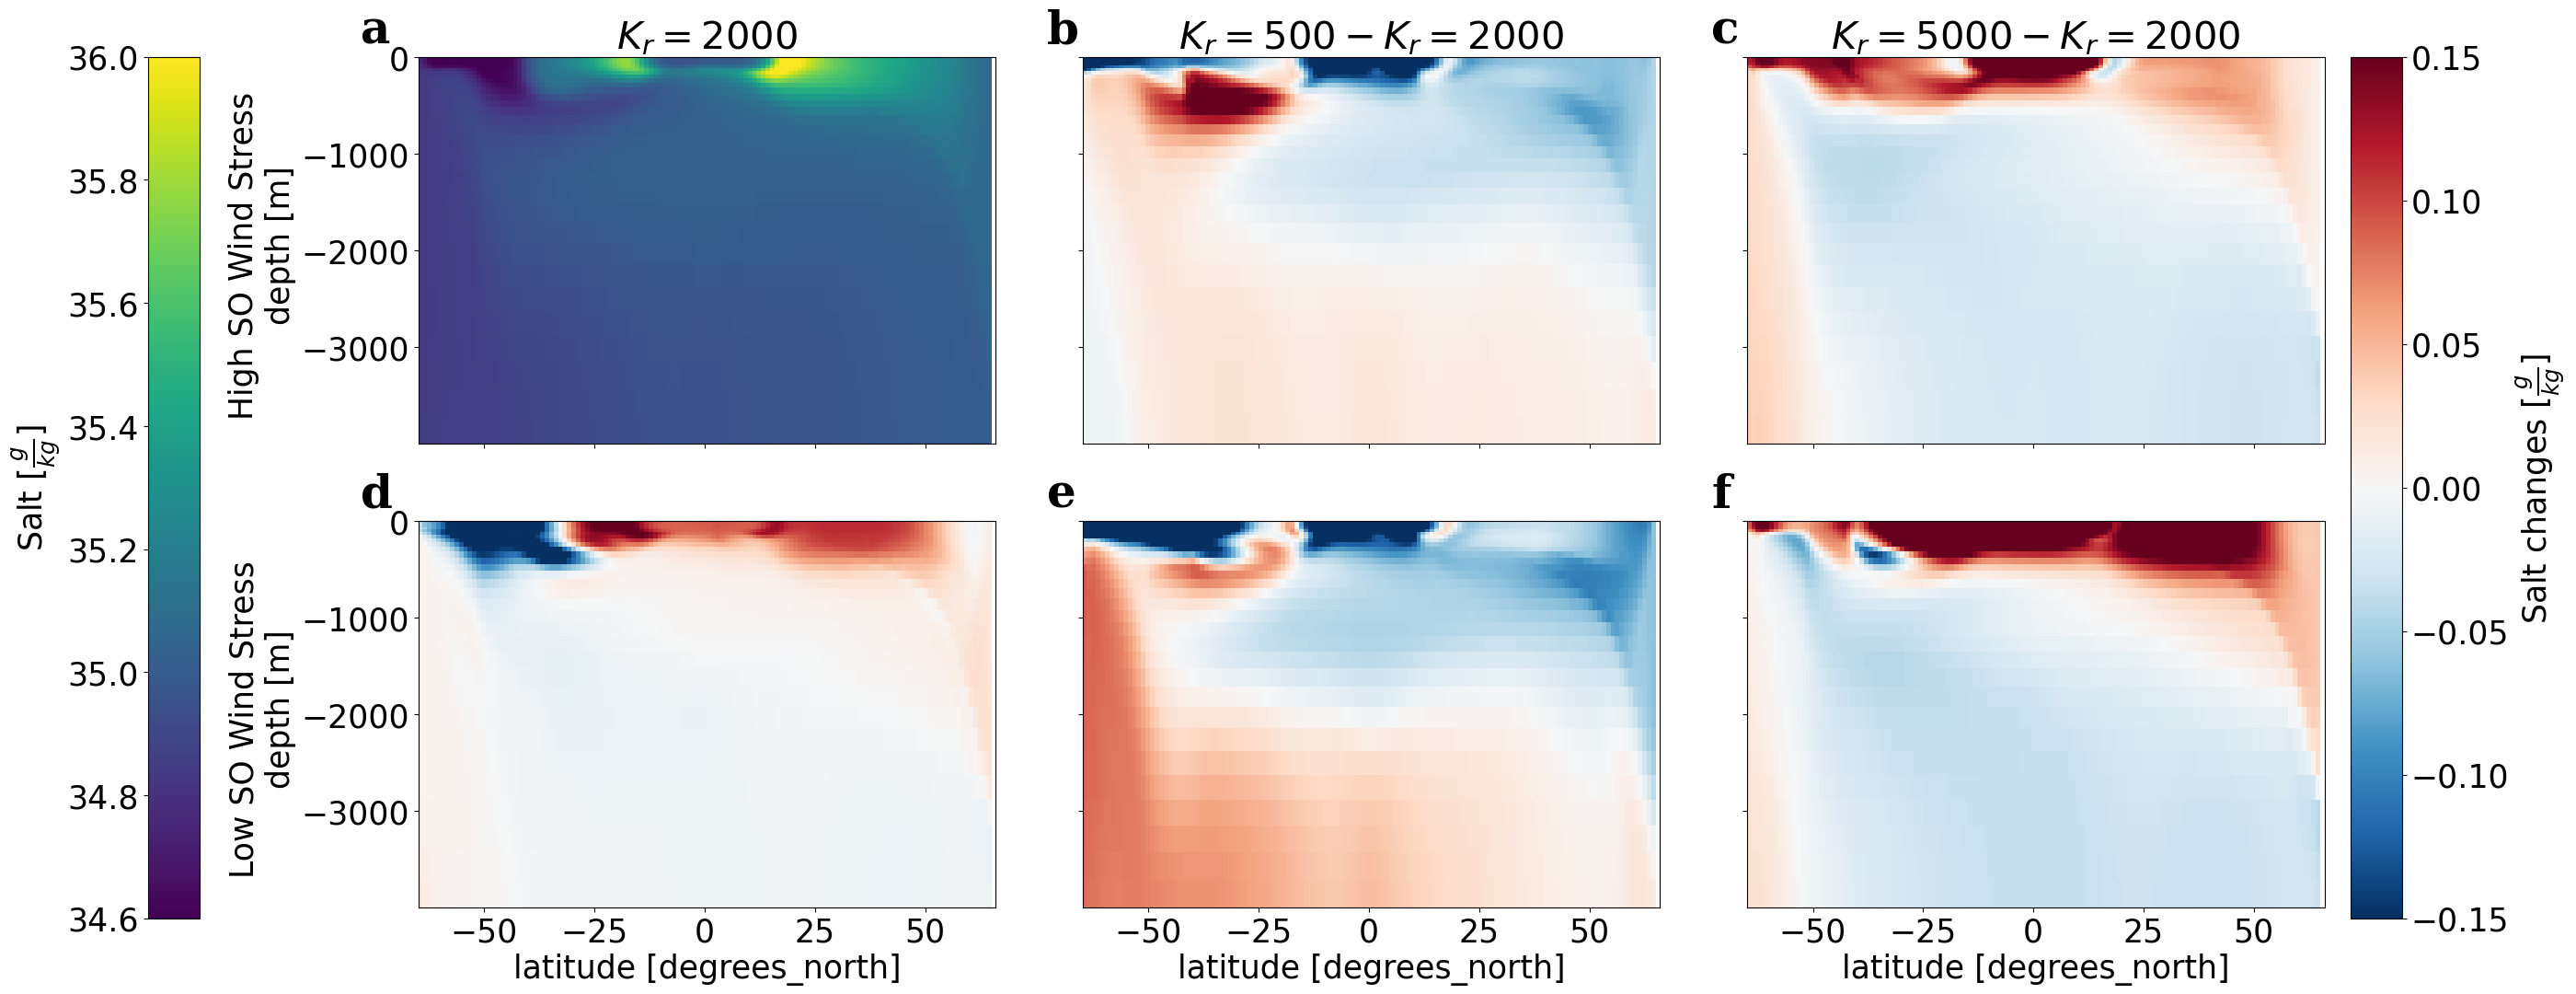

In [12]:
matplotlib.rcParams.update({'font.size': 25})
bouy2000=(dyn2000['SALT'].mean('time')*dyn2000['dxF']*dyn2000['hFacC']).sum('XC')/((dyn2000['dxF']*dyn2000['hFacC']).sum('XC'))
bouy5000=(dyn5000['SALT'].mean('time')*dyn5000['dxF']*dyn5000['hFacC']).sum('XC')/((dyn5000['dxF']*dyn5000['hFacC']).sum('XC'))
bouy500=(dyn500['SALT'].mean('time')*dyn500['dxF']*dyn500['hFacC']).sum('XC')/((dyn500['dxF']*dyn500['hFacC']).sum('XC'))
bouy20002=(dyn20002['SALT'].mean('time')*dyn20002['dxF']*dyn20002['hFacC']).sum('XC')/((dyn20002['dxF']*dyn20002['hFacC']).sum('XC'))
bouy50002=(dyn50002['SALT'].mean('time')*dyn50002['dxF']*dyn50002['hFacC']).sum('XC')/((dyn50002['dxF']*dyn50002['hFacC']).sum('XC'))
bouy5002=(dyn5002['SALT'].mean('time')*dyn5002['dxF']*dyn5002['hFacC']).sum('XC')/((dyn5002['dxF']*dyn5002['hFacC']).sum('XC'))

mins=-.15
maxs=.15

fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(28,12),sharey=True,sharex=True)
(bouy5000-bouy20002).plot(ax=axs[1,2],vmin=mins,vmax=maxs,cmap='RdBu_r',add_colorbar=False)
(bouy2000-bouy20002).plot(ax=axs[1,0],vmin=mins,vmax=maxs,cmap='RdBu_r',add_colorbar=False)
(bouy500-bouy20002).plot(ax=axs[1,1],vmin=mins,vmax=maxs,cmap='RdBu_r',add_colorbar=False)
(bouy50002-bouy20002).plot(ax=axs[0,2],vmin=mins,vmax=maxs,cmap='RdBu_r',add_colorbar=False)
b=(bouy20002).plot(ax=axs[0,0],cmap='viridis',add_colorbar=False,vmin=34.6,vmax=36)
a=(bouy5002-bouy20002).plot(ax=axs[0,1],vmin=mins,vmax=maxs,cmap='RdBu_r',add_colorbar=False)

cax = plt.axes([0.91, 0.1, 0.02, 0.78])
plt.colorbar(a, cax=cax,label='Salt changes [' +r'$\frac{g}{kg}$'+']')

cax = plt.axes([0.055, 0.1, 0.02, 0.78])
plt.colorbar(b, cax=cax,label='Salt ['+r'$\frac{g}{kg}$'+']',ticklocation='left')
axs[0,2].set_title(r'$K_r=5000 - K_r=2000$')
axs[0,0].set_title(r'$K_r=2000$')
axs[0,1].set_title(r'$K_r=500 - K_r=2000$')

axs[1,0].set_ylabel('Low SO Wind Stress \n depth [m]')
axs[0,1].set_ylabel('')
axs[0,2].set_ylabel('')

axs[0,0].set_xlabel('')
axs[0,1].set_xlabel('')
axs[0,2].set_xlabel('')

axs[0,0].set_ylabel('High SO Wind Stress \n depth [m]')
axs[1,1].set_ylabel('')
axs[1,2].set_ylabel('')
plt.subplots_adjust(left=.16,wspace=0.15,hspace=0.2)


axs[0,0].text(-78.0, 500.0, 'a',
            fontsize='x-large', verticalalignment='top', fontfamily='serif', fontweight='bold')
axs[0,1].text(-73.0, 500.0, 'b',
            fontsize='x-large', verticalalignment='top', fontfamily='serif', fontweight='bold')
axs[0,2].text(-73.0, 500.0, 'c',
            fontsize='x-large', verticalalignment='top', fontfamily='serif', fontweight='bold')
axs[1,0].text(-78.0, 500.0, 'd',
            fontsize='x-large', verticalalignment='top', fontfamily='serif', fontweight='bold')
axs[1,1].text(-73.0, 500.0, 'e',
            fontsize='x-large', verticalalignment='top', fontfamily='serif', fontweight='bold')
axs[1,2].text(-73.0, 500.0, 'f',
            fontsize='x-large', verticalalignment='top', fontfamily='serif', fontweight='bold')

plt.savefig('diff_Salt.png')

/scratch/user/nicole.neumann-2/.conda/envs/myjup/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


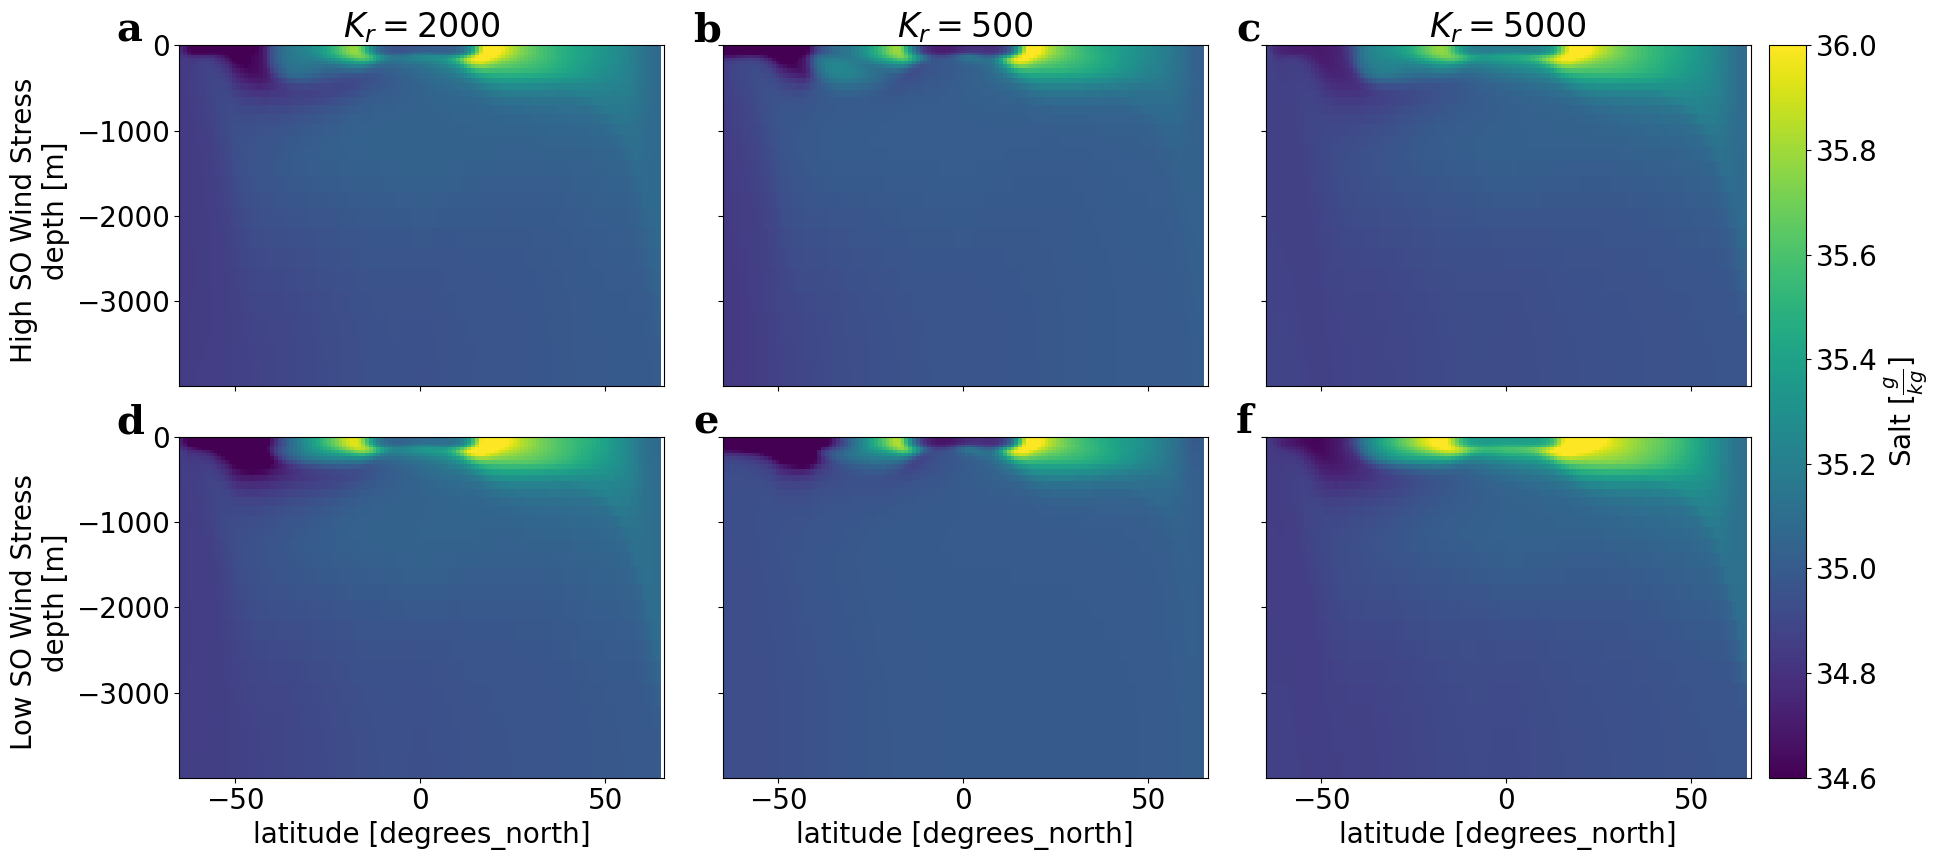

In [6]:
fig, axs = plt.subplots(ncols=3,nrows=2,figsize=(21,9),sharex=True)
bouy2000=(dyn2000['SALT'].mean('time')*dyn2000['dxF']*dyn2000['hFacC']).sum('XC')/((dyn2000['dxF']*dyn2000['hFacC']).sum('XC'))
bouy5000=(dyn5000['SALT'].mean('time')*dyn5000['dxF']*dyn5000['hFacC']).sum('XC')/((dyn5000['dxF']*dyn5000['hFacC']).sum('XC'))
bouy500=(dyn500['SALT'].mean('time')*dyn500['dxF']*dyn500['hFacC']).sum('XC')/((dyn500['dxF']*dyn500['hFacC']).sum('XC'))
bouy20002=(dyn20002['SALT'].mean('time')*dyn20002['dxF']*dyn20002['hFacC']).sum('XC')/((dyn20002['dxF']*dyn20002['hFacC']).sum('XC'))
bouy50002=(dyn50002['SALT'].mean('time')*dyn50002['dxF']*dyn50002['hFacC']).sum('XC')/((dyn50002['dxF']*dyn50002['hFacC']).sum('XC'))
bouy5002=(dyn5002['SALT'].mean('time')*dyn5002['dxF']*dyn5002['hFacC']).sum('XC')/((dyn5002['dxF']*dyn5002['hFacC']).sum('XC'))

mins=34.6
maxs=36

(bouy5000).plot(ax=axs[1,2],vmin=mins,vmax=maxs,cmap='viridis',add_colorbar=False)
(bouy2000).plot(ax=axs[1,0],vmin=mins,vmax=maxs,cmap='viridis',add_colorbar=False)
(bouy500).plot(ax=axs[1,1],vmin=mins,vmax=maxs,cmap='viridis',add_colorbar=False)
(bouy50002).plot(ax=axs[0,2],vmin=mins,vmax=maxs,cmap='viridis',add_colorbar=False)
b=(bouy20002).plot(ax=axs[0,0],cmap='viridis',add_colorbar=False,vmin=mins,vmax=maxs)
a=(bouy5002).plot(ax=axs[0,1],vmin=mins,vmax=maxs,cmap='viridis',add_colorbar=False)

axs[1,1].set_yticklabels([])
axs[1,2].set_yticklabels([])
axs[0,1].set_yticklabels([])
axs[0,2].set_yticklabels([])
axs[0,0].set_title(r'$K_r=2000$')
axs[0,1].set_ylabel(' ')
axs[1,1].set_ylabel(' ')
axs[1,2].set_ylabel(' ')
axs[0,1].set_xlabel(' ')
axs[1,0].set_ylabel('Low SO Wind Stress \n depth [m]')
axs[0,0].set_ylabel('High SO Wind Stress \n depth [m]')
axs[0,0].set_xlabel(' ')
axs[0,2].set_ylabel(' ')
axs[0,2].set_xlabel(' ')
axs[0,2].set_title(r'$K_r=5000$')
axs[0,1].set_title(r'$K_r=500$')
fig.tight_layout()
plt.subplots_adjust(wspace=0.12,hspace=0.15)
plt.colorbar(a,ax=axs,pad=.01,label='Salt ['+r'$\frac{g}{kg}$'+']')

axs[0,0].text(-82.0, 400.0, 'a',
            fontsize='x-large', verticalalignment='top', fontfamily='serif', fontweight='bold')
axs[0,1].text(-73.0, 400.0, 'b',
            fontsize='x-large', verticalalignment='top', fontfamily='serif', fontweight='bold')
axs[0,2].text(-73.0, 400.0, 'c',
            fontsize='x-large', verticalalignment='top', fontfamily='serif', fontweight='bold')
axs[1,0].text(-82.0, 400.0, 'd',
            fontsize='x-large', verticalalignment='top', fontfamily='serif', fontweight='bold')
axs[1,1].text(-73.0, 400.0, 'e',
            fontsize='x-large', verticalalignment='top', fontfamily='serif', fontweight='bold')
axs[1,2].text(-73.0, 400.0, 'f',
            fontsize='x-large', verticalalignment='top', fontfamily='serif', fontweight='bold')

plt.savefig('Salt.png')